In [1]:
%load_ext google.cloud.bigquery

In [130]:
import numpy as np 
import pandas as pd
import os
os.environ["GOOGLE_APPLICATION_CREDENTIALS"]="/home/shuang/Downloads/bqair-2b59936a9500.json"

# Big query helpers
from google.cloud import bigquery
from bq_helper import BigQueryHelper

# Import plotting libaries
import matplotlib.pyplot as plt
import plotly.graph_objs as go
import plotly.plotly as py
import plotly.figure_factory as ff
import plotly.io as pio
import geopandas
import shapely

# the Plotly in offline mode we can see map in the notebook.
from plotly.offline import download_plotlyjs,init_notebook_mode, plot,iplot
init_notebook_mode(connected=True)

In [132]:
import plotly
plotly.tools.set_credentials_file(username='cleopathy', api_key='Vt9pQQVXJcV8bqHarLVt')

In [26]:
#getting CO daily summary data first:
QUERY = """
    SELECT
        state_code,
        county_code,
        date_local,
        arithmetic_mean,
        state_name,
        county_name,
        aqi
    FROM
      `bigquery-public-data.epa_historical_air_quality.co_daily_summary`
    WHERE
      poc = 1
      AND EXTRACT(YEAR FROM date_local) in (2004,2005,2006,2007,2008,2009,2010,2011,2012,2013,2014,2015,2016,2017)
    
        """

In [27]:
bq_assistant = BigQueryHelper("bigquery-public-data", "epa_historical_air_quality")

In [28]:
df_co = bq_assistant.query_to_pandas(QUERY) # getting data through big query to pandas

In [29]:
df_co.head()

,state_code,county_code,date_local,arithmetic_mean,state_name,county_name,aqi
0,02,020,2009-01-23,0.400000,Alaska,Anchorage,NaN
1,02,020,2010-11-06,0.562500,Alaska,Anchorage,NaN
2,48,245,2007-07-16,0.237500,Texas,Jefferson,3.0
3,48,309,2011-07-15,0.100000,Texas,McLennan,NaN
4,02,020,2011-12-28,0.354167,Alaska,Anchorage,NaN


In [30]:
df_co['date_local'] = pd.to_datetime(df_co['date_local'])
df_co['year'] = df_co['date_local'].dt.year
df_co['month'] = df_co['date_local'].dt.month
import calendar
df_co['month_name'] = df_co['month'].apply(lambda x: calendar.month_abbr[x])
df_co['aqi'].fillna(df_co['aqi'].mean(), inplace = True)
df_co.head()

,state_code,county_code,date_local,arithmetic_mean,state_name,county_name,aqi,year,month,month_name
0,02,020,2009-01-23,0.400000,Alaska,Anchorage,6.411328,2009,1,Jan
1,02,020,2010-11-06,0.562500,Alaska,Anchorage,6.411328,2010,11,Nov
2,48,245,2007-07-16,0.237500,Texas,Jefferson,3.000000,2007,7,Jul
3,48,309,2011-07-15,0.100000,Texas,McLennan,6.411328,2011,7,Jul
4,02,020,2011-12-28,0.354167,Alaska,Anchorage,6.411328,2011,12,Dec


In [31]:
df_co.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3181940 entries, 0 to 81939
Data columns (total 10 columns):
state_code         object
county_code        object
date_local         datetime64[ns]
arithmetic_mean    float64
state_name         object
county_name        object
aqi                float64
year               int64
month              int64
month_name         object
dtypes: datetime64[ns](1), float64(2), int64(2), object(5)
memory usage: 267.0+ MB


In [32]:
df_co.drop_duplicates()
df_co.info()   #means there is no duplicate rows, that's good.

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3181940 entries, 0 to 81939
Data columns (total 10 columns):
state_code         object
county_code        object
date_local         datetime64[ns]
arithmetic_mean    float64
state_name         object
county_name        object
aqi                float64
year               int64
month              int64
month_name         object
dtypes: datetime64[ns](1), float64(2), int64(2), object(5)
memory usage: 267.0+ MB


In [39]:
#make a new data frame of avg aqi value with each year.
df_co_avg = df_co.groupby('year')['aqi'].mean()
df_co_avg = df_co_avg.reset_index()
df_co_avg.head(10)

,year,aqi
0,2004,7.878685
1,2005,7.536522
2,2006,7.282775
3,2007,6.796480
4,2008,6.471870
5,2009,6.267285
6,2010,6.085429
7,2011,5.996953
8,2012,5.856599
9,2013,5.633861


In [61]:
#getting no2 data:
QUERY = """
    SELECT
        state_code,
        county_code,
        date_local,
        arithmetic_mean,
        state_name,
        county_name,
        aqi
    FROM
      `bigquery-public-data.epa_historical_air_quality.no2_daily_summary`
    WHERE
      poc = 1
      AND EXTRACT(YEAR FROM date_local) in (2004,2005,2006,2007,2008,2009,2010,2011,2012,2013,2014,2015,2016,2017)
    
        """

In [62]:
bq_assistant = BigQueryHelper("bigquery-public-data", "epa_historical_air_quality")
df_no2 = bq_assistant.query_to_pandas(QUERY) # getting data through big query to pandas
df_no2['date_local'] = pd.to_datetime(df_no2['date_local'])
df_no2['year'] = df_no2['date_local'].dt.year
df_no2['month'] = df_no2['date_local'].dt.month
import calendar
df_no2['month_name'] = df_no2['month'].apply(lambda x: calendar.month_abbr[x])
df_no2['aqi'].fillna(df_no2['aqi'].mean(), inplace = True)
df_no2.head()

,state_code,county_code,date_local,arithmetic_mean,state_name,county_name,aqi,year,month,month_name
0,02,090,2014-08-25,3.754545,Alaska,Fairbanks North Star,7,2014,8,Aug
1,02,090,2014-12-20,26.145833,Alaska,Fairbanks North Star,30,2014,12,Dec
2,21,145,2014-01-02,5.478261,Kentucky,McCracken,11,2014,1,Jan
3,21,145,2014-04-14,2.739130,Kentucky,McCracken,7,2014,4,Apr
4,21,145,2014-04-29,3.434783,Kentucky,McCracken,8,2014,4,Apr


In [63]:
df_no2.info() 
df_no2.drop_duplicates()
df_no2.info() 

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1817962 entries, 0 to 17961
Data columns (total 10 columns):
state_code         object
county_code        object
date_local         datetime64[ns]
arithmetic_mean    float64
state_name         object
county_name        object
aqi                int64
year               int64
month              int64
month_name         object
dtypes: datetime64[ns](1), float64(1), int64(3), object(5)
memory usage: 152.6+ MB
<class 'pandas.core.frame.DataFrame'>
Int64Index: 1817962 entries, 0 to 17961
Data columns (total 10 columns):
state_code         object
county_code        object
date_local         datetime64[ns]
arithmetic_mean    float64
state_name         object
county_name        object
aqi                int64
year               int64
month              int64
month_name         object
dtypes: datetime64[ns](1), float64(1), int64(3), object(5)
memory usage: 152.6+ MB


In [64]:
#make a new data frame of avg aqi value with each year.
df_no2_avg = df_no2.groupby('year')['aqi'].mean()
df_no2_avg = df_no2_avg.reset_index()
df_no2_avg.head(10)

,year,aqi
0,2004,22.682083
1,2005,23.192578
2,2006,22.330629
3,2007,21.458110
4,2008,20.488159
5,2009,18.648870
6,2010,17.837795
7,2011,17.296794
8,2012,16.519207
9,2013,16.014426


In [69]:
#getting so2 data:
QUERY = """
    SELECT
        state_code,
        county_code,
        date_local,
        arithmetic_mean,
        state_name,
        county_name,
        aqi
    FROM
      `bigquery-public-data.epa_historical_air_quality.so2_daily_summary`
    WHERE
      poc = 1
      AND EXTRACT(YEAR FROM date_local) in (2004,2005,2006,2007,2008,2009,2010,2011,2012,2013,2014,2015,2016,2017)
    
        """

In [70]:
bq_assistant = BigQueryHelper("bigquery-public-data", "epa_historical_air_quality")
df_so2 = bq_assistant.query_to_pandas(QUERY) # getting data through big query to pandas
df_so2['date_local'] = pd.to_datetime(df_so2['date_local'])
df_so2['year'] = df_so2['date_local'].dt.year
df_so2['month'] = df_so2['date_local'].dt.month
import calendar
df_so2['month_name'] = df_so2['month'].apply(lambda x: calendar.month_abbr[x])
df_so2['aqi'].fillna(df_so2['aqi'].mean(), inplace = True)
df_so2.head()

,state_code,county_code,date_local,arithmetic_mean,state_name,county_name,aqi,year,month,month_name
0,80,002,2007-07-22,1.375000,Country Of Mexico,BAJA CALIFORNIA NORTE,10.765094,2007,7,Jul
1,80,002,2007-10-06,0.100000,Country Of Mexico,BAJA CALIFORNIA NORTE,10.765094,2007,10,Oct
2,80,002,2007-12-17,4.475000,Country Of Mexico,BAJA CALIFORNIA NORTE,10.765094,2007,12,Dec
3,80,002,2007-04-18,1.866667,Country Of Mexico,BAJA CALIFORNIA NORTE,10.765094,2007,4,Apr
4,80,002,2007-08-01,0.352941,Country Of Mexico,BAJA CALIFORNIA NORTE,1.000000,2007,8,Aug


In [71]:
df_so2.info() 
df_so2.drop_duplicates()
df_so2.info() 

<class 'pandas.core.frame.DataFrame'>
Int64Index: 4138947 entries, 0 to 38946
Data columns (total 10 columns):
state_code         object
county_code        object
date_local         datetime64[ns]
arithmetic_mean    float64
state_name         object
county_name        object
aqi                float64
year               int64
month              int64
month_name         object
dtypes: datetime64[ns](1), float64(2), int64(2), object(5)
memory usage: 347.4+ MB
<class 'pandas.core.frame.DataFrame'>
Int64Index: 4138947 entries, 0 to 38946
Data columns (total 10 columns):
state_code         object
county_code        object
date_local         datetime64[ns]
arithmetic_mean    float64
state_name         object
county_name        object
aqi                float64
year               int64
month              int64
month_name         object
dtypes: datetime64[ns](1), float64(2), int64(2), object(5)
memory usage: 347.4+ MB


In [72]:
#make a new data frame of avg aqi value with each year.
df_so2_avg = df_so2.groupby('year')['aqi'].mean()
df_so2_avg = df_so2_avg.reset_index()
df_so2_avg.head(10)

,year,aqi
0,2004,13.680637
1,2005,13.706285
2,2006,12.859992
3,2007,12.460845
4,2008,12.393448
5,2009,11.208482
6,2010,10.983708
7,2011,10.090269
8,2012,9.642984
9,2013,8.962827


In [73]:
#getting pm10 data:
QUERY = """
    SELECT
        state_code,
        county_code,
        date_local,
        arithmetic_mean,
        state_name,
        county_name,
        aqi
    FROM
      `bigquery-public-data.epa_historical_air_quality.pm10_daily_summary`
    WHERE
      poc = 1
      AND EXTRACT(YEAR FROM date_local) in (2004,2005,2006,2007,2008,2009,2010,2011,2012,2013,2014,2015,2016,2017)
    
        """

In [74]:
bq_assistant = BigQueryHelper("bigquery-public-data", "epa_historical_air_quality")
df_pm10 = bq_assistant.query_to_pandas(QUERY) # getting data through big query to pandas
df_pm10['date_local'] = pd.to_datetime(df_pm10['date_local'])
df_pm10['year'] = df_pm10['date_local'].dt.year
df_pm10['month'] = df_pm10['date_local'].dt.month
import calendar
df_pm10['month_name'] = df_pm10['month'].apply(lambda x: calendar.month_abbr[x])
df_pm10['aqi'].fillna(df_pm10['aqi'].mean(), inplace = True)
df_pm10.head()

,state_code,county_code,date_local,arithmetic_mean,state_name,county_name,aqi,year,month,month_name
0,78,010,2008-11-02,15.0,Virgin Islands,St Croix,14,2008,11,Nov
1,78,030,2008-09-04,15.0,Virgin Islands,St Thomas,14,2008,9,Sep
2,78,010,2014-10-02,22.0,Virgin Islands,St Croix,20,2014,10,Oct
3,78,010,2009-01-06,12.0,Virgin Islands,St Croix,11,2009,1,Jan
4,78,010,2009-08-08,37.0,Virgin Islands,St Croix,34,2009,8,Aug


In [75]:
df_pm10.info() 
df_pm10.drop_duplicates()
df_pm10.info() 

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1057934 entries, 0 to 57933
Data columns (total 10 columns):
state_code         1057934 non-null object
county_code        1057934 non-null object
date_local         1057934 non-null datetime64[ns]
arithmetic_mean    1057934 non-null float64
state_name         1057934 non-null object
county_name        1057934 non-null object
aqi                1057934 non-null int64
year               1057934 non-null int64
month              1057934 non-null int64
month_name         1057934 non-null object
dtypes: datetime64[ns](1), float64(1), int64(3), object(5)
memory usage: 88.8+ MB
<class 'pandas.core.frame.DataFrame'>
Int64Index: 1057934 entries, 0 to 57933
Data columns (total 10 columns):
state_code         1057934 non-null object
county_code        1057934 non-null object
date_local         1057934 non-null datetime64[ns]
arithmetic_mean    1057934 non-null float64
state_name         1057934 non-null object
county_name        1057934 non-null 

In [76]:
#make a new data frame of avg aqi value with each year.
df_pm10_avg = df_pm10.groupby('year')['aqi'].mean()
df_pm10_avg = df_pm10_avg.reset_index()
df_pm10_avg.head(10)

,year,aqi
0,2004,21.739366
1,2005,22.647988
2,2006,23.583810
3,2007,23.976989
4,2008,22.121403
5,2009,19.733361
6,2010,19.380494
7,2011,20.045083
8,2012,21.187193
9,2013,18.792015


In [97]:
# getting pm25 data:
QUERY = """
    SELECT
        state_code,
        county_code,
        date_local,
        arithmetic_mean,
        state_name,
        county_name,
        aqi
    FROM
      `bigquery-public-data.epa_historical_air_quality.pm25_frm_daily_summary`
    WHERE
      poc = 1
      AND EXTRACT(YEAR FROM date_local) in (2004,2005,2006,2007,2008,2009,2010,2011,2012,2013,2014,2015,2016,2017)
    
        """

In [98]:
bq_assistant = BigQueryHelper("bigquery-public-data", "epa_historical_air_quality")
df_pm25 = bq_assistant.query_to_pandas(QUERY) # getting data through big query to pandas
df_pm25['date_local'] = pd.to_datetime(df_pm25['date_local'])
df_pm25['year'] = df_pm25['date_local'].dt.year
df_pm25['month'] = df_pm25['date_local'].dt.month
import calendar
df_pm25['month_name'] = df_pm25['month'].apply(lambda x: calendar.month_abbr[x])
df_pm25['aqi'].fillna(df_pm25['aqi'].mean(), inplace = True)
df_pm25.head()

,state_code,county_code,date_local,arithmetic_mean,state_name,county_name,aqi,year,month,month_name
0,78,010,2004-12-29,3.0,Virgin Islands,St Croix,13.0,2004,12,Dec
1,78,010,2004-09-30,3.0,Virgin Islands,St Croix,13.0,2004,9,Sep
2,78,030,2006-10-14,7.2,Virgin Islands,St Thomas,30.0,2006,10,Oct
3,78,030,2005-09-19,4.4,Virgin Islands,St Thomas,18.0,2005,9,Sep
4,78,010,2006-03-24,4.7,Virgin Islands,St Croix,20.0,2006,3,Mar


In [99]:
df_pm25.info() 
df_pm25.drop_duplicates()
df_pm25.info() 

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1844133 entries, 0 to 44132
Data columns (total 10 columns):
state_code         object
county_code        object
date_local         datetime64[ns]
arithmetic_mean    float64
state_name         object
county_name        object
aqi                float64
year               int64
month              int64
month_name         object
dtypes: datetime64[ns](1), float64(2), int64(2), object(5)
memory usage: 154.8+ MB
<class 'pandas.core.frame.DataFrame'>
Int64Index: 1844133 entries, 0 to 44132
Data columns (total 10 columns):
state_code         object
county_code        object
date_local         datetime64[ns]
arithmetic_mean    float64
state_name         object
county_name        object
aqi                float64
year               int64
month              int64
month_name         object
dtypes: datetime64[ns](1), float64(2), int64(2), object(5)
memory usage: 154.8+ MB


In [100]:
#make a new data frame of avg aqi value with each year.
df_pm25_avg = df_pm25.groupby('year')['aqi'].mean()
df_pm25_avg = df_pm25_avg.reset_index()
df_pm25_avg.head(10)

,year,aqi
0,2004,44.337561
1,2005,46.355775
2,2006,43.386945
3,2007,44.789185
4,2008,41.605292
5,2009,38.302030
6,2010,38.708147
7,2011,38.123289
8,2012,36.587268
9,2013,35.640725


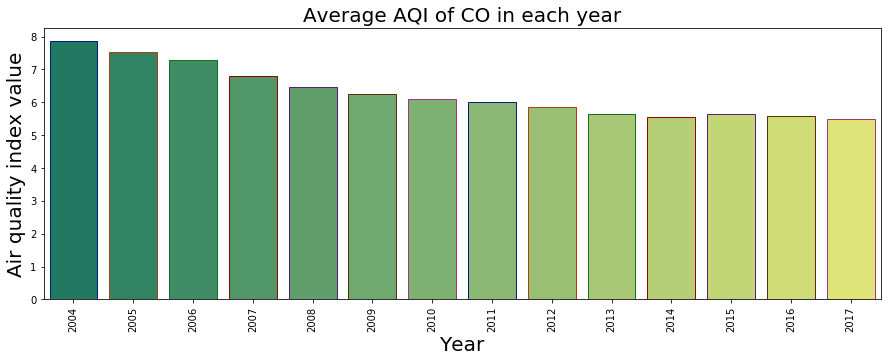

In [67]:
#visualize co :
plt.subplots(figsize=(15,5))
sns.barplot(x='year',y='aqi',data=df_co_avg,palette='summer',edgecolor=sns.color_palette('dark',7))
plt.ylabel('Air quality index value', fontsize=20)
plt.xticks(rotation=90)
plt.xlabel('Year', fontsize=20)
plt.title('Average AQI of CO in each year', fontsize=20)
plt.show()

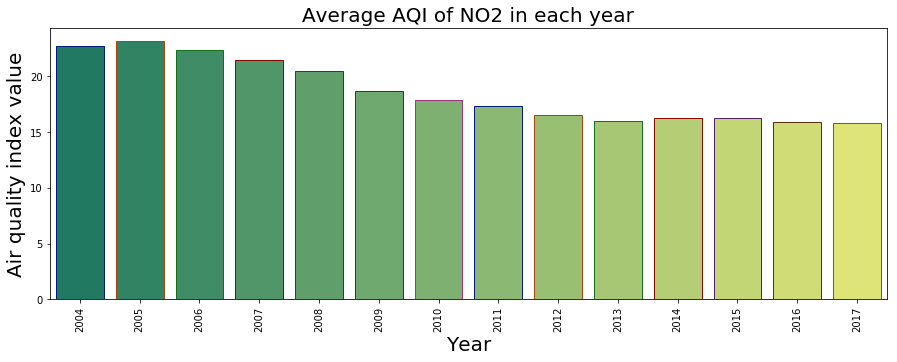

In [68]:
#visualize no2 
plt.subplots(figsize=(15,5))
sns.barplot(x='year',y='aqi',data=df_no2_avg,palette='summer',edgecolor=sns.color_palette('dark',7))
plt.ylabel('Air quality index value', fontsize=20)
plt.xticks(rotation=90)
plt.xlabel('Year', fontsize=20)
plt.title('Average AQI of NO2 in each year', fontsize=20)
plt.show()

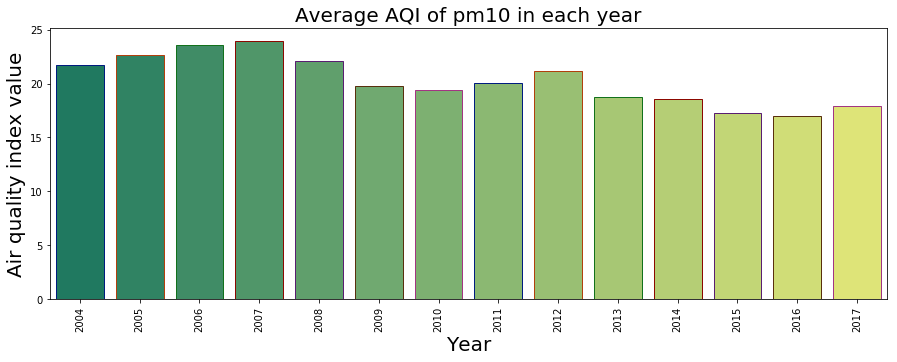

In [77]:
#visualize pm10:
plt.subplots(figsize=(15,5))
sns.barplot(x='year',y='aqi',data=df_pm10_avg,palette='summer',edgecolor=sns.color_palette('dark',7))
plt.ylabel('Air quality index value', fontsize=20)
plt.xticks(rotation=90)
plt.xlabel('Year', fontsize=20)
plt.title('Average AQI of pm10 in each year', fontsize=20)
plt.show()

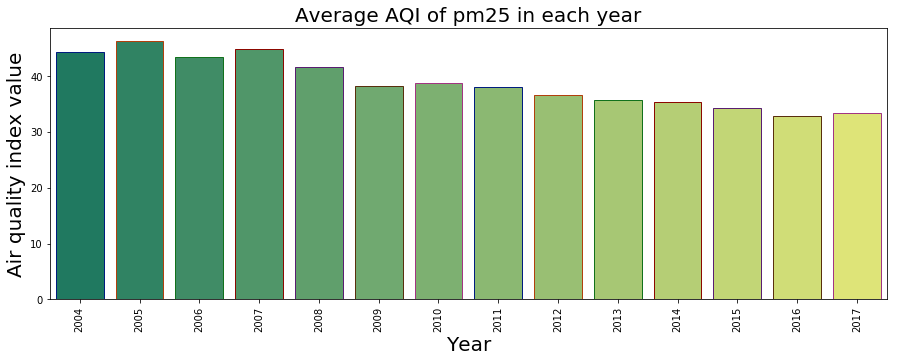

In [82]:
#visualize pm25 
plt.subplots(figsize=(15,5))
sns.barplot(x='year',y='aqi',data=df_pm25_avg,palette='summer',edgecolor=sns.color_palette('dark',7))
plt.ylabel('Air quality index value', fontsize=20)
plt.xticks(rotation=90)
plt.xlabel('Year', fontsize=20)
plt.title('Average AQI of pm25 in each year', fontsize=20)
plt.show()

In [ ]:
#now we visualize average aqi of each year for every month:

In [57]:
def year_data(year):
    df = df_co[df_co.year == year ]
    df['aqi_mean_of_year'] = df.aqi.mean()
    return df

In [58]:
co_2011 = year_data(2011)
co_2011.head()

,state_code,county_code,date_local,arithmetic_mean,state_name,county_name,aqi,year,month,month_name,aqi_mean_of_year
3,48,309,2011-07-15,0.100000,Texas,McLennan,6.411328,2011,7,Jul,5.996953
4,02,020,2011-12-28,0.354167,Alaska,Anchorage,6.411328,2011,12,Dec,5.996953
20,42,043,2011-12-21,0.483333,Pennsylvania,Dauphin,7.000000,2011,12,Dec,5.996953
37,42,043,2011-12-21,0.487500,Pennsylvania,Dauphin,6.411328,2011,12,Dec,5.996953
42,48,309,2011-07-14,0.100000,Texas,McLennan,1.000000,2011,7,Jul,5.996953


In [59]:
co_2012 = year_data(2012)
co_2013 = year_data(2013)
co_2014 = year_data(2014)
co_2015 = year_data(2015)
co_2016 = year_data(2016)

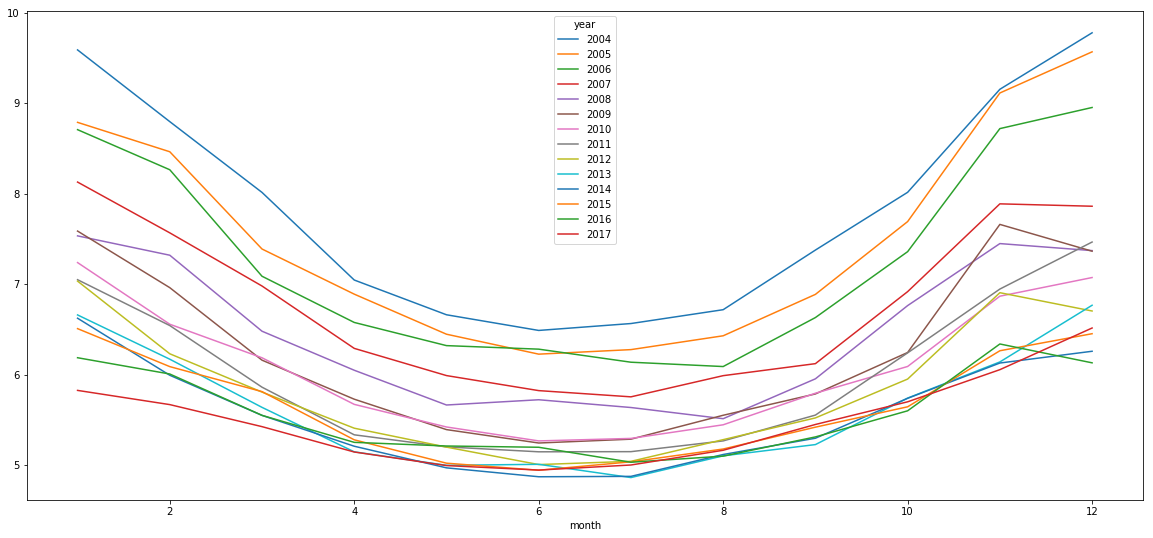

In [84]:
import matplotlib.dates as mdates
myFmt = mdates.DateFormatter('%m')

x = df_co.date_local
y1 = co_2011.aqi_mean_of_year
y2 = co_2012.aqi_mean_of_year
y3 = co_2013.aqi_mean_of_year
y4 = co_2014.aqi_mean_of_year
y5 = co_2015.aqi_mean_of_year
y6 = co_2016.aqi_mean_of_year

fig,ax = plt.subplots(figsize = (20,9))
plt.rc('legend',fontsize='medium') 
df_co.groupby(['month','year']).mean()['aqi'].unstack().plot(ax=ax)


In [158]:
#now we explore pm25 average AQI for massachusetts each county:

#getting pm25 data:
target_pm25 = df_pm25
target_pm25['state_name'] = target_pm25['state_name'].str.upper() 
target_pm25 = target_pm25[target_pm25['state_name'] == 'TEXAS']
target_pm25.head()

,state_code,county_code,date_local,arithmetic_mean,state_name,county_name,aqi,year,month,month_name
11583,48,201,2017-07-16,9.458333,TEXAS,Harris,38.865911,2017,7,Jul
11584,48,361,2017-10-07,10.809524,TEXAS,Orange,38.865911,2017,10,Oct
11585,48,361,2017-10-19,17.583333,TEXAS,Orange,38.865911,2017,10,Oct
11586,48,361,2017-09-11,12.541667,TEXAS,Orange,38.865911,2017,9,Sep
11587,48,201,2017-08-08,6.625000,TEXAS,Harris,38.865911,2017,8,Aug


In [160]:
target_pm25['location_code']=target_pm25['state_code']+target_pm25['county_code']
tg_pm25_avg = target_pm25.groupby('location_code')['aqi'].mean()
tg_pm25_avg = tg_pm25_avg.reset_index()
tg_pm25_avg.aqi = tg_pm25_avg.aqi.round()
tg_pm25_avg.head()

,location_code,aqi
0,48029,35.0
1,48037,43.0
2,48043,33.0
3,48061,38.0
4,48113,42.0


In [161]:
#now we see the average AQI in texas counties of pm2.5:
values = tg_pm25_avg['aqi'].tolist()
fips = tg_pm25_avg['location_code'].tolist()

colorscale = ["#8dd3c7", "#ffffb3", "#bebada", "#fb8072",
              "#80b1d3", "#fdb462", "#b3de69", "#fccde5",
              "#d9d9d9", "#bc80bd", "#ccebc5", "#ffed6f",
              "#8dd3c7", "#ffffb3", "#bebada", "#fb8072"]
#endpts = list(np.linspace(1, 5, len(colorscale) - 1))
#endpts = list(np.linspace(min(values), max(values), 2)

fig = ff.create_choropleth(
    fips = fips, values = values, scope = ['Texas'],
    colorscale=colorscale,
    round_legend_values=True,
    plot_bgcolor='#8dd3c7',
    paper_bgcolor='rgb(229,229,229)',
    legend_title='AQI of pm25 of each county in texas',
    county_outline={'color': 'rgb(255,255,255)', 'width': 0.5},
    exponent_format=True,
)

py.iplot(fig)

/home/shuang/anaconda3/lib/python3.7/site-packages/IPython/core/display.py:689: UserWarning:

Consider using IPython.display.IFrame instead

